In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bilby
%matplotlib inline

14:35 bilby INFO    : Running bilby version: 0.3.1: (CLEAN) 06cce8b 2018-10-18 05:02:54 -0500


## This notebook will show how to use the PTMCMCSampler, in particular this will highlight how to add custom jump proposals

## create 150914 like injection

In [2]:
# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.
sampling_frequency = 2048.

# Specify the output directory and the name of the simulation.
outdir = 'outdir'
label = 'basic_tutorial4'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=2000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

# Fixed arguments passed into the source model
waveform_arguments = dict(waveform_approximant='IMRPhenomP',
                          reference_frequency=50., minimum_frequency=20.)

## Inject into data

In [3]:
# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments)

# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity

ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

/home/c1572221/src/bilby/bilby/gw/detector.py:1986: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
14:36 bilby INFO    : Injected signal in H1:
14:36 bilby INFO    :   optimal SNR = 12.09
14:36 bilby INFO    :   matched filter SNR = 10.88-0.37j
14:36 bilby INFO    :   luminosity_distance = 2000.0
14:36 bilby INFO    :   psi = 2.659
14:36 bilby INFO    :   a_2 = 0.3
14:36 bilby INFO    :   a_1 = 0.4
14:36 bilby INFO    :   geocent_time = 1126259642.41
14:36 bilby INFO    :   tilt_2 = 1.0
14:36 bilby INFO    :   phi_jl = 0.3
14:36 bilby INFO    :   ra = 1.375
14:36 bilby INFO    :   phase = 1.3
14:36 bilby INFO    :   mass_2 = 29.0
14:36 bilby INFO    :   mass_1 = 36.0
14:36 bilby INFO    :   phi_12 = 1.7
14:36 bilby INFO    :   dec = -1.2108
14:36 bilby INFO    :   iota = 0.4
14:36 bilby INFO    :   tilt_1 = 0.5
14:36 bilby INFO    : Injected signal in L1:
14:36 bilby INFO    

[{'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'plus': array([-0.-0.j, -0.-0.j, -0.-0.j, ..., -0.-0.j, -0.-0.j,
         -0.-0.j])},
 {'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'plus': array([-0.-0.j, -0.-0.j, -0.-0.j, ..., -0.-0.j, -0.-0.j,
         -0.-0.j])}]

### For simplicity, we will fix all parameters here to the injected value and only vary over mass1 and mass2,

In [4]:
priors = injection_parameters.copy()
priors['mass_1'] = bilby.prior.Uniform(name='mass_1', minimum=10, maximum=80, unit=r'$M_{\\odot}$')
priors['mass_2'] = bilby.prior.Uniform(name='mass_1', minimum=10, maximum=80, unit=r'$M_{\\odot}$')

## Here we create arbitrary jump proposals. This will highlight the necessary features of a jump proposal in ptmcmc. That is it takes the current position, x, then outputs a new position , q,  and the jump probability i.e. p(x -> q). These will then be passed to the standard metropolis hastings condition. 
## The two proposals below are probably not very good ones, ideally we would use proposals based upon our kmowledge of the problem/parameter space. In general for these proposals lqxy will certainly not be 0 

In [5]:
class UniformJump(object):
    def __init__(self, pmin, pmax):
        """Draw random parameters from pmin, pmax"""
        self.pmin = pmin
        self.pmax = pmax
        
    def unjump(self, x, it, beta):
        """ 
        Function prototype must read in parameter vector x,
        sampler iteration number it, and inverse temperature beta
        """
        # log of forward-backward jump probability
        lqxy = 0
        
        # uniformly drawm parameters
        q = np.random.uniform(self.pmin, self.pmax, len(x))
        return q, lqxy

In [6]:
class NormJump(object):
    def __init__(self, step_size):
        """Draw random parameters from pmin, pmax"""
        self.step_size = step_size
        
    def normjump(self, x, it, beta):
        """ 
        Function prototype must read in parameter vector x,
        sampler iteration number it, and inverse temperature beta
        """
        # log of forward-backward jump probability. this is only zero for simple examples.
        lqxy = 0
        
        # uniformly drawm parameters
        q = np.random.multivariate_normal(x , self.step_size * np.eye(len(x)) , 1)
        return q[0], lqxy

### Below we create a dictionary containing our jump proposals and the relative weight of that proposal in the proposal cycle, these are then passed to bilby.run_sampler under the keyword argument custom_proposals = 

In [7]:
normjump = NormJump(1)
normweight = 5
ujump = UniformJump(20, 40)
uweight = 1 
custom = {'uniform': [ujump.unjump , uweight],
          'normal': [normjump.normjump , normweight]}

In [9]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveoform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,waveform_generator=waveform_generator)
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler= 'PTMCMCsampler',custom_proposals = custom , Niter = 10**4 )

14:36 bilby INFO    : Running for label 'label', output will be saved to 'outdir'
14:36 bilby INFO    : Search parameters:
14:36 bilby INFO    :   mass_2 = Uniform(minimum=10, maximum=80, name='mass_1', latex_label='$m_1$', unit='$M_{\\\\odot}$')
14:36 bilby INFO    :   mass_1 = Uniform(minimum=10, maximum=80, name='mass_1', latex_label='$m_1$', unit='$M_{\\\\odot}$')
14:36 bilby INFO    :   phi_jl = 0.3
14:36 bilby INFO    :   dec = -1.2108
14:36 bilby INFO    :   psi = 2.659
14:36 bilby INFO    :   a_2 = 0.3
14:36 bilby INFO    :   a_1 = 0.4
14:36 bilby INFO    :   geocent_time = 1126259642.41
14:36 bilby INFO    :   luminosity_distance = 2000.0
14:36 bilby INFO    :   ra = 1.375
14:36 bilby INFO    :   phase = 1.3
14:36 bilby INFO    :   phi_12 = 1.7
14:36 bilby INFO    :   tilt_2 = 1.0
14:36 bilby INFO    :   iota = 0.4
14:36 bilby INFO    :   tilt_1 = 0.5
14:36 bilby INFO    : Single likelihood evaluation took 1.670e-03 s
14:36 bilby INFO    : Using sampler PTMCMCSampler with kwar

Finished 50.00 percent in 26.952440 s Acceptance rate = 0.1046667Adding DE jump with weight 1
Finished 90.00 percent in 47.835580 s Acceptance rate = 0.140667

14:37 bilby INFO    : Sampling time: 0:00:53.551375
14:37 bilby ERROR   : 

 Saving the data has failed with the following message:
 Can't pickle <type 'instancemethod'>: attribute lookup __builtin__.instancemethod failed 


14:37 bilby INFO    : Results saved to outdir/
14:37 bilby INFO    : Summary of results:
nsamples: 4000
log_noise_evidence: -8086.279
log_evidence:    nan +/-    nan
log_bayes_factor:    nan +/-    nan




Run Complete


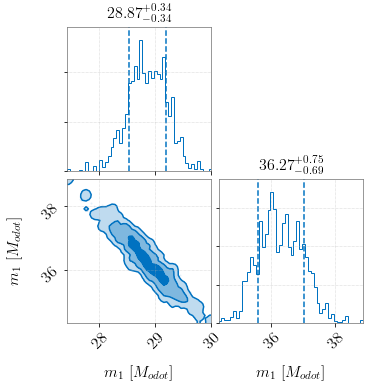

In [10]:
result.plot_corner()

### PTMCMC produces the acceptance rate for each of the proposals (including the ones built in). This is taken as an average at a specified checkpoint. This is one (acceptnace rate is certainly not the only/even the best metric here. Think exploration v exploitation problem ) indicators of whether our jump proposal is a good one

In [11]:
sampler_meta = result.meta_data['sampler_meta']
jumps = sampler_meta['proposals']

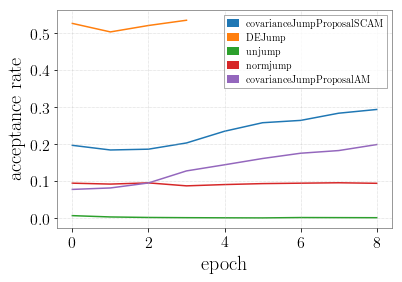

In [12]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('acceptance rate')
for i,proposal in enumerate(jumps): 
    plt.plot(jumps[proposal] , label = proposal)
plt.legend(loc='best', frameon=True)

## We can generate the 1d chains for each of the parameters too and the likelihood of those points on the chain

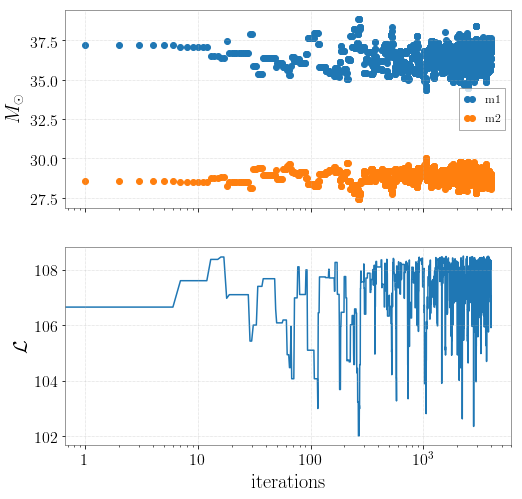

In [14]:
m2 = result.posterior.mass_2.values
m1 = result.posterior.mass_1.values

fig, ax = plt.subplots(nrows = 2 , ncols =1 , sharex = True , figsize = (8,8))
ax[0].plot(m1 , 'o', label = 'm1' )
ax[0].plot(m2 , 'o', label = 'm2' )
ax[0].set_ylabel(r'$M_{\odot}$')
ax[0].legend(loc = 'best' , frameon = True , fontsize = 12)
ax[1].plot(result.log_likelihood_evaluations)
ax[1].set_ylabel(r'$\mathcal{L}$')
ax[1].set_xlabel('iterations')
ax[1].set_xscale('log')